### Test deployed web application
This notebook pulls some images and tests them against the deployed web application.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from testing_utilities import img_url_to_json, to_img, plot_predictions
import requests
%matplotlib inline

In [2]:
service_json = !kubectl get service azure-dl -o json
service_dict = json.loads(''.join(service_json))
app_url = service_dict['status']['loadBalancer']['ingress'][0]['ip']

In [3]:
scoring_url = 'http://{}/score'.format(app_url)
version_url = 'http://{}/version'.format(app_url)

Quickly check the web application is working

In [4]:
!curl $version_url # Reports the Tensorflow Version

1.4.1

Pull an image of a Lynx to test it

In [5]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"

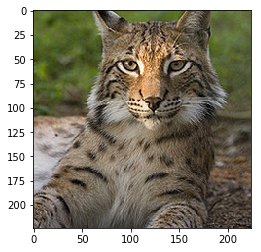

In [6]:
plt.imshow(to_img(IMAGEURL))

In [7]:
# headers = {'content-type': 'application/json','X-Marathon-App-Id': app_id}
headers = {'content-type': 'application/json'}
jsonimg = img_url_to_json(IMAGEURL)
r = requests.post(scoring_url, data=jsonimg, headers=headers) # Run the request twice since the first time takes a 
                                                              # little longer due to the loading of the model
%time r = requests.post(scoring_url, data=jsonimg, headers=headers)
r.json()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 260 ms


{'result': [{'image': [['n02127052 lynx, catamount', 0.9974517226219177],
    ['n02128385 leopard, Panthera pardus', 0.0015076971612870693],
    ['n02128757 snow leopard, ounce, Panthera uncia', 0.0005164768663235009]]},
  'Computed in 69.1 ms']}

From the results above we can see that the model correctly classifies this as an Lynx. 
The computation took around 70 ms and the whole round trip around 240 ms. The round trip time will depend on where the resuests are being made.

Lets try a few more images

In [8]:
images = ('https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/3/3a/Roadster_2.5_windmills_trimmed.jpg',
          'http://www.worldshipsociety.org/wp-content/themes/construct/lib/scripts/timthumb/thumb.php?src=http://www.worldshipsociety.org/wp-content/uploads/2013/04/stock-photo-5495905-cruise-ship.jpg&w=570&h=370&zc=1&q=100',
          'http://yourshot.nationalgeographic.com/u/ss/fQYSUbVfts-T7pS2VP2wnKyN8wxywmXtY0-FwsgxpiZv_E9ZfPsNV5B0ER8-bOdruvNfMD5EbP4SznWz4PYn/',
          'https://cdn.arstechnica.net/wp-content/uploads/2012/04/bohol_tarsier_wiki-4f88309-intro.jpg',
          'http://i.telegraph.co.uk/multimedia/archive/03233/BIRDS-ROBIN_3233998b.jpg')

In [9]:
results = [requests.post(scoring_url, data=img_url_to_json(img), headers=headers) for img in images]

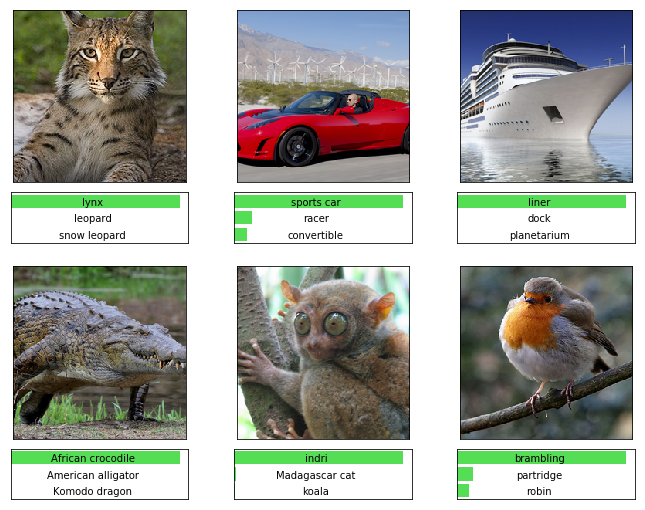

In [10]:
plot_predictions(images, results)

The labels predicted by our model seem to be consistent with the images supplied.

Next lets quickly check what the request response performance is for our deployed model.

In [11]:
image_data = list(map(img_url_to_json, images)) # Retrieve the images and data

In [12]:
timer_results = list()
for img in image_data:
    res=%timeit -r 1 -o -q requests.post(scoring_url, data=img, headers=headers)
    timer_results.append(res.best)

In [13]:
timer_results

[0.2653312631882727,
 0.20696204295381904,
 0.24133984791114926,
 0.2388763977214694,
 0.23505731904879212,
 0.26958796521648765]

In [14]:
print('Average time taken: {0:4.2f} ms'.format(10**3 * np.mean(timer_results)))

Average time taken: 242.86 ms


We have tested that the model works and we can mode on to the [next notebook to get sense of its throughput](06_SpeedTestWebApp.ipynb)  